## Dot product Attention

## Table of contents

* [Simple Example](#first-bullet)
  
* [Scaled Dot product Attention](#second-bullet)

  
* [Multi-Head Attention](#third-bullet)


* [Position-Wise Feed-Forward Network](#fourth-bullet)

  
* [Positional Encoding](#fifth-bullet)

## Query-Key-Value

- Query (Q): Represents the current token or word for which we want to find relevant information.
- Key (K): Represents all tokens or words in the sequence, acting as potential matches for the query.
- Value (V): Represents the actual information or content associated with each key.

## Simple Example <a class="anchor" id="first-bullet"></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /home/sridhanya_ganapathi_team_neustar/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

In [3]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x))

In [4]:
def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = np.array(output)
    del model  # free up space again
    return embeddings, words_pass


1. Computes Attention scores
2. matrix multiplication followed by normalization using softmax

In [5]:
def dot_product_attention(hidden_states, previous_state):

    # [T,d]*[d,N] -> [T,N]
    scores = np.matmul(previous_state, hidden_states.T)
    w_n = softmax(scores)

    # [T,N]*[N,d] -> [T,d]
    c_t = np.matmul(w_n, hidden_states)

    return w_n, c_t

In [6]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()

1. input query word
2. softmax gives the weights
3. multiply it with the context vector
4. Mask is used for padding

/var/tmp/ipykernel_47649/665568944.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


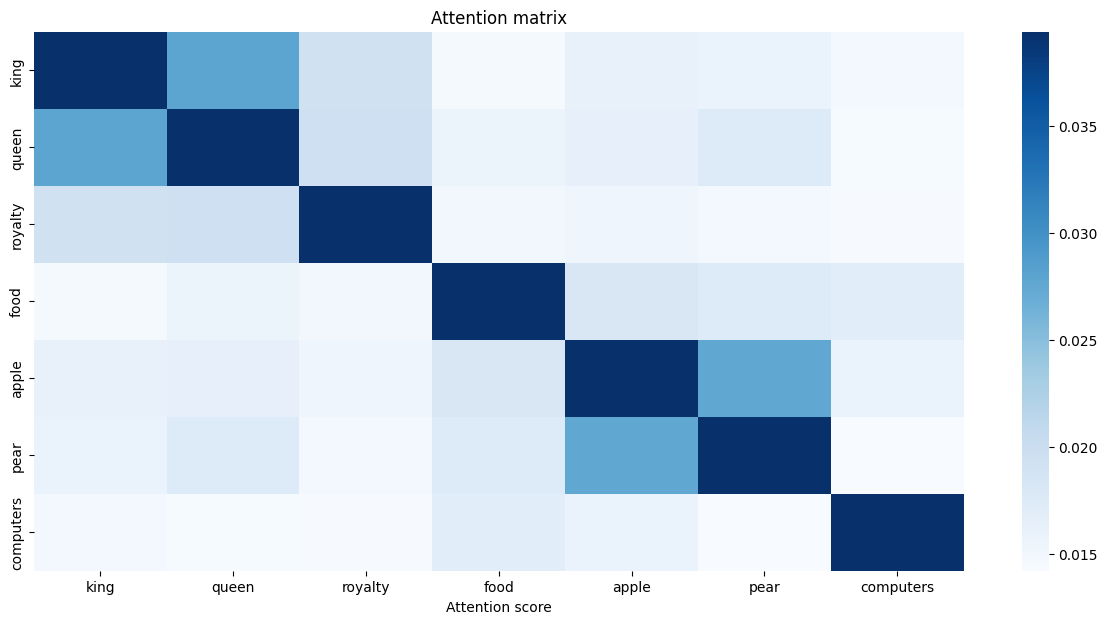

In [7]:
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

## Scaled Dot Product Attention Example <a class="anchor" id="second-bullet"></a>

The main difference is that scaled dot-product attention scales the dot product by the square root of the key vector's dimension, which helps stabilize training.

In [8]:
class ScaledDotProductAttention:
    def __init__(self, d_k):
        self.d_k = d_k

    def __call__(self, Q, K, V, mask=None):
        # Calculate the dot products between Q and K
        scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)  # Mask out padded tokens
        # Apply softmax to get the attention weights
        attn_weights = self.softmax(scores, axis=-1)
        
        # Multiply the attention weights with the values
        output = np.matmul(attn_weights, V)
        
        return output, attn_weights

    def softmax(self, x, axis=None):
        """Compute softmax values for each set of scores in x."""
        e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [9]:


# Test the Scaled Dot-Product Attention mechanism
def test_scaled_dot_product_attention():
    """
    Test the Scaled Dot-Product Attention mechanism.

    Validates:
    - Correct output shape.
    - Correct attention weights shape.
    - Attention weights sum to 1 across the sequence dimension.
    """
    print("Testing Scaled Dot-Product Attention...")
    batch_size = 2
    seq_length = 4
    d_k = 64

    # Create random tensors for Q, K, V
    Q = np.random.randn(batch_size, seq_length, d_k)
    K = np.random.randn(batch_size, seq_length, d_k)
    V = np.random.randn(batch_size, seq_length, d_k)

    # Instantiate your ScaledDotProductAttention
    attention = ScaledDotProductAttention(d_k)

    # Perform forward pass
    output, attn_weights = attention(Q, K, V)

    # Validate output shape
    assert output.shape == (batch_size, seq_length, d_k), \
        f"Expected output shape ({batch_size}, {seq_length}, {d_k}), got {output.shape}"

    # Validate attention weights shape
    assert attn_weights.shape == (batch_size, seq_length, seq_length), \
        f"Expected attn_weights shape ({batch_size}, {seq_length}, {seq_length}), got {attn_weights.shape}"

    # Validate that attention weights sum to 1
    attn_sums = attn_weights.sum(axis=-1)
    assert np.allclose(attn_sums, np.ones((batch_size, seq_length)), atol=1e-6), \
        "Attention weights should sum to 1 over the last dimension."

    print("Scaled Dot-Product Attention test passed.\n")


In [10]:

# Run the test
test_scaled_dot_product_attention()


Testing Scaled Dot-Product Attention...
Scaled Dot-Product Attention test passed.



## Multi-Head Attention Example <a class="anchor" id="third-bullet"></a>

multiple attention heads instead of a single attention function. Self-attention provides a context-aware representation for each element in a sequence. Multi-head self-attention refines this by allowing the model to learn different aspects of the relationships between elements, leading to a more robust understanding of the sequence

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [12]:

def test_multi_head_attention():
    """
    Test the Multi-Head Attention mechanism.

    Validates:
    - Correct output shape.
    - Correct functionality with masking (if implemented).
    """
    print("Testing Multi-Head Attention...")
    batch_size = 2
    seq_length = 4
    embed_dim = 64
    num_heads = 8

    # Create random tensor for input
    x = torch.randn(batch_size, seq_length, embed_dim)

    # Instantiate your MultiHeadAttention
    mha = MultiHeadAttention(embed_dim, num_heads)

    # Perform forward pass
    output = mha(x, x, x)

    # Validate output shape
    assert output.shape == (batch_size, seq_length, embed_dim), \
        f"Expected output shape ({batch_size}, {seq_length}, {embed_dim}), got {output.shape}"

    print("Multi-Head Attention test passed.\n")


In [13]:
test_multi_head_attention()

Testing Multi-Head Attention...
Multi-Head Attention test passed.



## Position-Wise Feed-Forward Network <a class="anchor" id="fourth-bullet"></a>

Position-Wise Feed-Forward Network captures positions of sequence

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [15]:

def test_position_wise_feed_forward():
    """
    Test the Position-Wise Feed-Forward Network.

    Validates:
    - Correct output shape.
    - Non-linear activation function is applied.
    """
    print("Testing Position-Wise Feed-Forward Network...")
    batch_size = 2
    seq_length = 4
    embed_dim = 64
    ff_dim = 256

    # Create random tensor for input
    x = torch.randn(batch_size, seq_length, embed_dim)

    # Instantiate your PositionWiseFeedForward
    ff = PositionWiseFeedForward(embed_dim, ff_dim)

    # Perform forward pass
    output = ff(x)

    # Validate output shape
    assert output.shape == (batch_size, seq_length, embed_dim), \
        f"Expected output shape ({batch_size}, {seq_length}, {embed_dim}), got {output.shape}"

    print("Position-Wise Feed-Forward Network test passed.\n")

In [16]:
test_position_wise_feed_forward()

Testing Position-Wise Feed-Forward Network...
Position-Wise Feed-Forward Network test passed.



## Positional Encoding <a class="anchor" id="fourth-bullet"></a>

Positional Encoding Matrix: Computes the positional encodings using sine and cosine functions.
This positional encoding helps the model to incorporate the order of the sequence, which is crucial for tasks like translation and text generation.Encoding Positional Information: Positional encoding adds a vector to each token embedding that represents its relative position in the sequence.



In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [18]:

def test_positional_encoding():
    """
    Test the Positional Encoding mechanism.

    Validates:
    - Correct output shape.
    - Positional encoding does not alter the input shape.
    """
    print("Testing Positional Encoding...")
    batch_size = 2
    seq_length = 4
    embed_dim = 64

    # Create zero tensor for input
    x = torch.zeros(batch_size, seq_length, embed_dim)

    # Instantiate your PositionalEncoding
    pe = PositionalEncoding(embed_dim, max_seq_length=seq_length)

    # Apply positional encoding
    output = pe(x)

    # Validate output shape
    assert output.shape == (batch_size, seq_length, embed_dim), \
        f"Expected output shape ({batch_size}, {seq_length}, {embed_dim}), got {output.shape}"

    # Check that positional encoding adds information
    assert not torch.allclose(output, x), "Positional encoding should modify the input tensor."

    print("Positional Encoding test passed.\n")
    

In [19]:
test_positional_encoding()

Testing Positional Encoding...
Positional Encoding test passed.



Key Components:¶
Multi-Head Attention: Enables the model to capture long-range dependencies within the input sequence.

Position-Wise Feed-Forward Network: Enhances representations with local processing and non-linear transformations.

Layer Normalization: Stabilizes training and accelerates convergence by normalizing intermediate representations.

Residual Connections: Facilitate information flow and prevent vanishing gradients by adding the input to the output of each sub-layer.

Dropout: Regularizes the model and prevents overfitting by randomly masking a portion of the input units during training.

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

While the encoder layers focus on understanding the input sequence, the decoder layers play a dual role:

Decoding the Output Sequence: Generating the output sequence one token at a time. Attending to Relevant Information: Paying attention to both the previously generated output tokens and the encoded input sequence.
Key Components:
Self-Attention: Similar to encoder layers, allows the decoder to attend to previous outputs for context.

Encoder-Decoder Attention: Enables the decoder to attend to relevant parts of the encoded input sequence, crucial for tasks like machine translation.

Position-Wise Feed-Forward Network: Enhances representations within each position of the decoder output.

Layer Normalization, Residual Connections, and Dropout: Serve the same purposes as in encoder layers, stabilizing training and preventing overfitting.

Implementation:
The DecoderLayer class implements this architecture, incorporating both self-attention and encoder-decoder attention.

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

Key Components:¶
Embedding Layers: Project input tokens into a dense vector representation for processing within the model.

Positional Encoding: Incorporates positional information into the embeddings.

Encoder and Decoder Stacks: Composed of multiple encoder and decoder layers, respectively, forming the heart of the Transformer's architecture.

Masking: Employed during training to prevent the model from attending to future positions in the output sequence, ensuring proper decoding.

Final Linear Layer: Projects the decoder's output to the target vocabulary for generating predictions.

Implementation:
The Transformer class embodies this architecture, orchestrating the flow of information through its various components.

In [22]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [23]:
    
def test_full_transformer_layer():
    """
    Test the integration of all components in a Transformer Encoder Layer.

    Validates:
    - Correct output shape.
    - Data flow through the combined components.
    """
    print("Testing Full Transformer Encoder Layer...")
    batch_size = 2
    seq_length = 4
    embed_dim = 64
    num_heads = 8
    ff_dim = 256

    # Create random tensor for input
    x = torch.randn(batch_size, seq_length, embed_dim)
    
    # Instantiate the TransformerEncoderLayer
    encoder_layer = EncoderLayer(embed_dim, num_heads, ff_dim,dropout = 0.1)
    mask=None
    # Perform forward pass
    output = encoder_layer(x,mask)

    # Validate output shape
    assert output.shape == (batch_size, seq_length, embed_dim), \
        f"Expected output shape ({batch_size}, {seq_length}, {embed_dim}), got {output.shape}"

    print("Full Transformer Encoder Layer test passed.\n")


In [24]:
test_full_transformer_layer()

Testing Full Transformer Encoder Layer...
Full Transformer Encoder Layer test passed.

